# Examples 
## [Australian Tourism Hierarchy](https://otexts.com/fpp2/hts.html)

In this showcase we are going to use Australian Tourism data that shows number of visitors in Australian in a quarterly period from 1998 to 2016. This is exactly the same data Hyndman uses in his book with a little modification that first we transformed it to a long format because we think most datasets are storaged in this way, so we will do a step by step demonstration of how we treat our data before fitting any model.

In [2]:
# Usual imports
import sys

sys.path.append("../src")

import os
from pprint import pprint
import importlib

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Download the raw files into this directory
data = '../data/raw/'

# helper functions
from visualize import get_nodes_edges_position, make_annotations

sns.set_context("poster")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading Data

In [3]:
DATAPATH = os.path.join(data, "visnights")
os.listdir(DATAPATH)

['visnights.csv']

In [4]:
visnights = pd.read_csv(os.path.join(DATAPATH, "visnights.csv"))
visnights.head(7)

date state   zone  total_visitors_nights
0  1998-01-01   NSW  Metro            9047.095397
1  1998-04-01   NSW  Metro            6962.125890
2  1998-07-01   NSW  Metro            6871.963047
3  1998-10-01   NSW  Metro            7147.292612
4  1999-01-01   NSW  Metro            7956.922814
5  1999-04-01   NSW  Metro            6542.243263
6  1999-07-01   NSW  Metro            6330.364078

The hierarchy in this dataset is the following:
 - six geographic areas (NSW, QLD, SAU, VIC, WAU, OTH)
 - each geographic area can have a different number of zones, for example, NSW has five.
 
So in order to produce unique bottom series, let's create a new column where we concatenate state and zone.

In [5]:
visnights["state_zone"] = visnights.apply(lambda x: f"{x['state']}_{x['zone']}", axis=1)

### Visualizing Tree Structure

Let's create a simple plot of our tree structure so we can develop a better understanding of our dataset. We will use networkx and plotly to produce the visualization, so we need to create a list of tuples for each connection.

In [6]:
grouped_sections = visnights.groupby(["state", "state_zone"])
edges_hierarchy = list(grouped_sections.groups.keys())
edges_hierarchy[:7]

[('NSW', 'NSW_Metro'),
 ('NSW', 'NSW_NthCo'),
 ('NSW', 'NSW_NthIn'),
 ('NSW', 'NSW_SthCo'),
 ('NSW', 'NSW_SthIn'),
 ('OTH', 'OTH_Metro'),
 ('OTH', 'OTH_NoMet')]

Now, we must not forget total that is our root node.

In [7]:
second_level_nodes = ["NSW", "OTH", "WAU", "SAU", "QLD", "VIC"]
root_node = "total"

root_edges = [(root_node, second_level_node) for second_level_node in second_level_nodes]
root_edges

[('total', 'NSW'),
 ('total', 'OTH'),
 ('total', 'WAU'),
 ('total', 'SAU'),
 ('total', 'QLD'),
 ('total', 'VIC')]

In [8]:
root_edges += edges_hierarchy

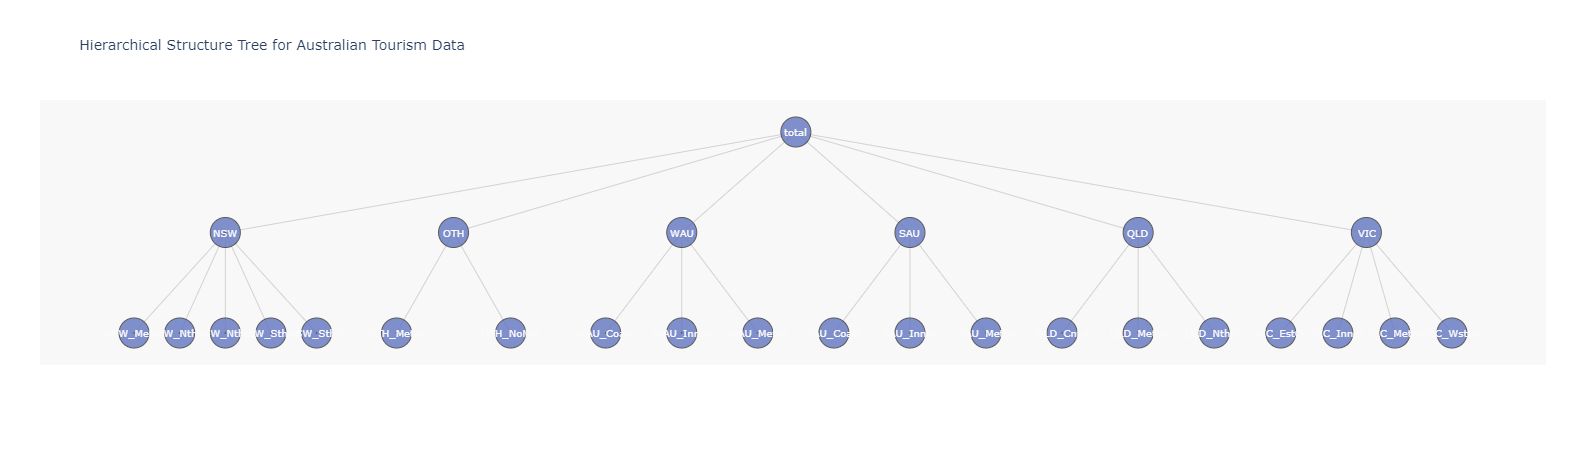

In [9]:
Xn, Yn, Xe, Ye, labels, annot = get_nodes_edges_position(root_edges, root="total")
M = max(Yn)

fig = go.Figure()

fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none'
                   ))

fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  name='bla',
                  marker=dict(symbol='circle-dot',
                                size=30,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=labels,
                  hoverinfo='text',
                  opacity=0.8
                  ))

axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )

fig.update_layout(title= 'Hierarchical Structure Tree for Australian Tourism Data',
              annotations=annot,
              font_size=10,
              showlegend=False,
              xaxis=axis,
              yaxis=axis,
              margin=dict(l=40, r=40, b=85, t=100),
              hovermode='closest',
              plot_bgcolor='rgb(248,248,248)'
              )
fig.show()

We can see above how our data is structured, now let's transform it in order to use scikit-hts properly.

### Transform data in the format required by scikit-hts

*scikit-hts* requires that each column in our DataFrame is a time series of its own, for all hierarchy levels. Let's do that. Remember that our data is in a long format.

The steps are the following:

1. Transform dataset into a column oriented one
2. Create the hierarchy representation as a dictionary
 
For a complete description of how that is done under the hood, and for a sense of what the API accepts, see [scikit-hts' docs](https://scikit-hts.readthedocs.io/en/latest/hierarchy.html)

In [10]:
visnights_bottom_level = visnights.pivot(index="date", columns="state_zone", values="total_visitors_nights")
visnights_bottom_level.head(5)

state_zone    NSW_Metro    NSW_NthCo    NSW_NthIn    NSW_SthCo    NSW_SthIn  \
date                                                                          
1998-01-01  9047.095397  8565.677890  2977.506662  5818.028804  2679.537963   
1998-04-01  6962.125890  7124.468362  3477.702717  2466.436706  3010.732155   
1998-07-01  6871.963047  4716.893116  3014.770331  1928.052834  3328.869005   
1998-10-01  7147.292612  6269.299065  3757.972112  2797.555974  2417.772236   
1999-01-01  7956.922814  9493.901336  3790.759900  4853.680680  3224.285428   

state_zone    OTH_Metro    OTH_NoMet    QLD_Cntrl     QLD_Metro    QLD_NthCo  \
date                                                                           
1998-01-01  3437.923945  2073.469372  2748.373689  12106.052376  2137.234012   
1998-04-01  2677.081107  1787.938519  4040.915256   7786.686688  2269.595619   
1998-07-01  3793.742887  2345.020634  5343.964347  11380.023616  4890.227020   
1998-10-01  3304.231082  1943.688721  4260.418878   9311.460272  2621.548165   
1999-01-01  3510.818728  2165.837870  4186.113263  12671.941529  2483.202540   

state_zone    SAU_Coast    SAU_Inner    SAU_Metro    VIC_EstCo    VIC_Inner  \
date                                                                          
1998-01-01  2591.997218   894.877294  2881.371786  3381.972183  5326.655137   
1998-04-01  1375.780128   979.250884  2124.735577  1827.940100  4441.118574   
1998-07-01  1079.541542   980.328853  2284.870236  1351.952120  3815.645302   
1998-10-01  1497.663951  1509.434264  1785.888968  1493.414796  3859.567145   
1999-01-01  2247.683952   963.522662  2293.872588  2896.928893  4588.755209   

state_zone    VIC_Metro    VIC_WstCo    WAU_Coast    WAU_Inner    WAU_Metro  
date                                                                         
1998-01-01  7490.381649  2442.004813  3066.555070   694.995372  3075.778941  
1998-04-01  5198.178082   960.504703  3334.405408   557.679575  2154.928814  
1998-07-01  5244.217363   755.974380  4365.844091  1006.184417  2787.286174  
1998-10-01  6274.245607  1271.603970  4521.995729  1172.551447  2752.909841  
1999-01-01  9187.421553  2385.058308  3579.346592   398.182909  3519.564374

We still need data aggregate by state and the total column.

In [11]:
def get_state_columns(df, state):
    return [col for col in df.columns if state in col]

states = visnights["state"].unique().tolist()

for state in states:
    state_cols = get_state_columns(visnights_bottom_level, state)
    visnights_bottom_level[state] = visnights_bottom_level[state_cols].sum(axis=1)

visnights_bottom_level["total"] = visnights_bottom_level[states].sum(axis=1)

visnights_bottom_level.head(5)

state_zone    NSW_Metro    NSW_NthCo    NSW_NthIn    NSW_SthCo    NSW_SthIn  \
date                                                                          
1998-01-01  9047.095397  8565.677890  2977.506662  5818.028804  2679.537963   
1998-04-01  6962.125890  7124.468362  3477.702717  2466.436706  3010.732155   
1998-07-01  6871.963047  4716.893116  3014.770331  1928.052834  3328.869005   
1998-10-01  7147.292612  6269.299065  3757.972112  2797.555974  2417.772236   
1999-01-01  7956.922814  9493.901336  3790.759900  4853.680680  3224.285428   

state_zone    OTH_Metro    OTH_NoMet    QLD_Cntrl     QLD_Metro    QLD_NthCo  \
date                                                                           
1998-01-01  3437.923945  2073.469372  2748.373689  12106.052376  2137.234012   
1998-04-01  2677.081107  1787.938519  4040.915256   7786.686688  2269.595619   
1998-07-01  3793.742887  2345.020634  5343.964347  11380.023616  4890.227020   
1998-10-01  3304.231082  1943.688721  4260.418878   9311.460272  2621.548165   
1999-01-01  3510.818728  2165.837870  4186.113263  12671.941529  2483.202540   

state_zone  ...    WAU_Coast    WAU_Inner    WAU_Metro           NSW  \
date        ...                                                        
1998-01-01  ...  3066.555070   694.995372  3075.778941  29087.846716   
1998-04-01  ...  3334.405408   557.679575  2154.928814  23041.465829   
1998-07-01  ...  4365.844091  1006.184417  2787.286174  19860.548333   
1998-10-01  ...  4521.995729  1172.551447  2752.909841  22389.891997   
1999-01-01  ...  3579.346592   398.182909  3519.564374  29319.550158   

state_zone           QLD          SAU           VIC          WAU          OTH  \
date                                                                            
1998-01-01  16991.660077  6368.246298  18641.013782  6837.329383  5511.393317   
1998-04-01  14097.197563  4479.766589  12427.741460  6047.013796  4465.019627   
1998-07-01  21614.214983  4344.740630  11167.789164  8159.314681  6138.763522   
1998-10-01  16193.427315  4792.987183  12898.831518  8447.457017  5247.919803   
1999-01-01  19341.257332  5505.079202  19058.163963  7497.093876  5676.656598   

state_zone         total  
date                      
1998-01-01  83437.489573  
1998-04-01  64558.204863  
1998-07-01  71285.371313  
1998-10-01  69970.514833  
1999-01-01  86397.801129  

[5 rows x 27 columns]

Now that we have our dataset ready, let's define our hierarchy tree. We need a dictionary, where each key is a column (node) in our hierarchy and a list of its children.

In [12]:
hierarchy = dict()

for edge in root_edges:
    parent, children = edge[0], edge[1]
    hierarchy.get(parent)
    if not hierarchy.get(parent):
        hierarchy[parent] = [children]
    else:
        hierarchy[parent] += [children]

In [13]:
hierarchy

{'total': ['NSW', 'OTH', 'WAU', 'SAU', 'QLD', 'VIC'],
 'NSW': ['NSW_Metro', 'NSW_NthCo', 'NSW_NthIn', 'NSW_SthCo', 'NSW_SthIn'],
 'OTH': ['OTH_Metro', 'OTH_NoMet'],
 'QLD': ['QLD_Cntrl', 'QLD_Metro', 'QLD_NthCo'],
 'SAU': ['SAU_Coast', 'SAU_Inner', 'SAU_Metro'],
 'VIC': ['VIC_EstCo', 'VIC_Inner', 'VIC_Metro', 'VIC_WstCo'],
 'WAU': ['WAU_Coast', 'WAU_Inner', 'WAU_Metro']}

### Fitting our models

Let's fit a few different models in our data and compare results.

In [14]:
# Does not change anything in data, except for index to be QS
visnights_bottom_level.index = pd.to_datetime(visnights_bottom_level.index)
visnights_bottom_level = visnights_bottom_level.resample("QS").sum()

#### Auto-Arima

First let's use scikit-hts to fit an ARIMA model specifically, the auto-arima implemented in the excellent pmdarima library.

In [15]:
from hts import HTSRegressor
from pmdarima.model_selection import train_test_split

train, test = train_test_split(visnights_bottom_level, test_size=8)

print(f"train shape: {train.shape}\t test shape: {test.shape}")

clf = HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0, m=4)
model = clf.fit(train, hierarchy)

Fitting models:   0%|          | 0/27 [00:00<?, ?it/s]

train shape: (68, 27)	 test shape: (8, 27)


Fitting models: 100%|██████████| 27/27 [04:38<00:00, 10.30s/it]


Now we can predict results for each node.

In [16]:
predicted_autoarima = model.predict(steps_ahead=8)

Fitting models: 100%|██████████| 27/27 [00:00<00:00, 93.18it/s]


Let's visualize the model results and fitted values for all states.

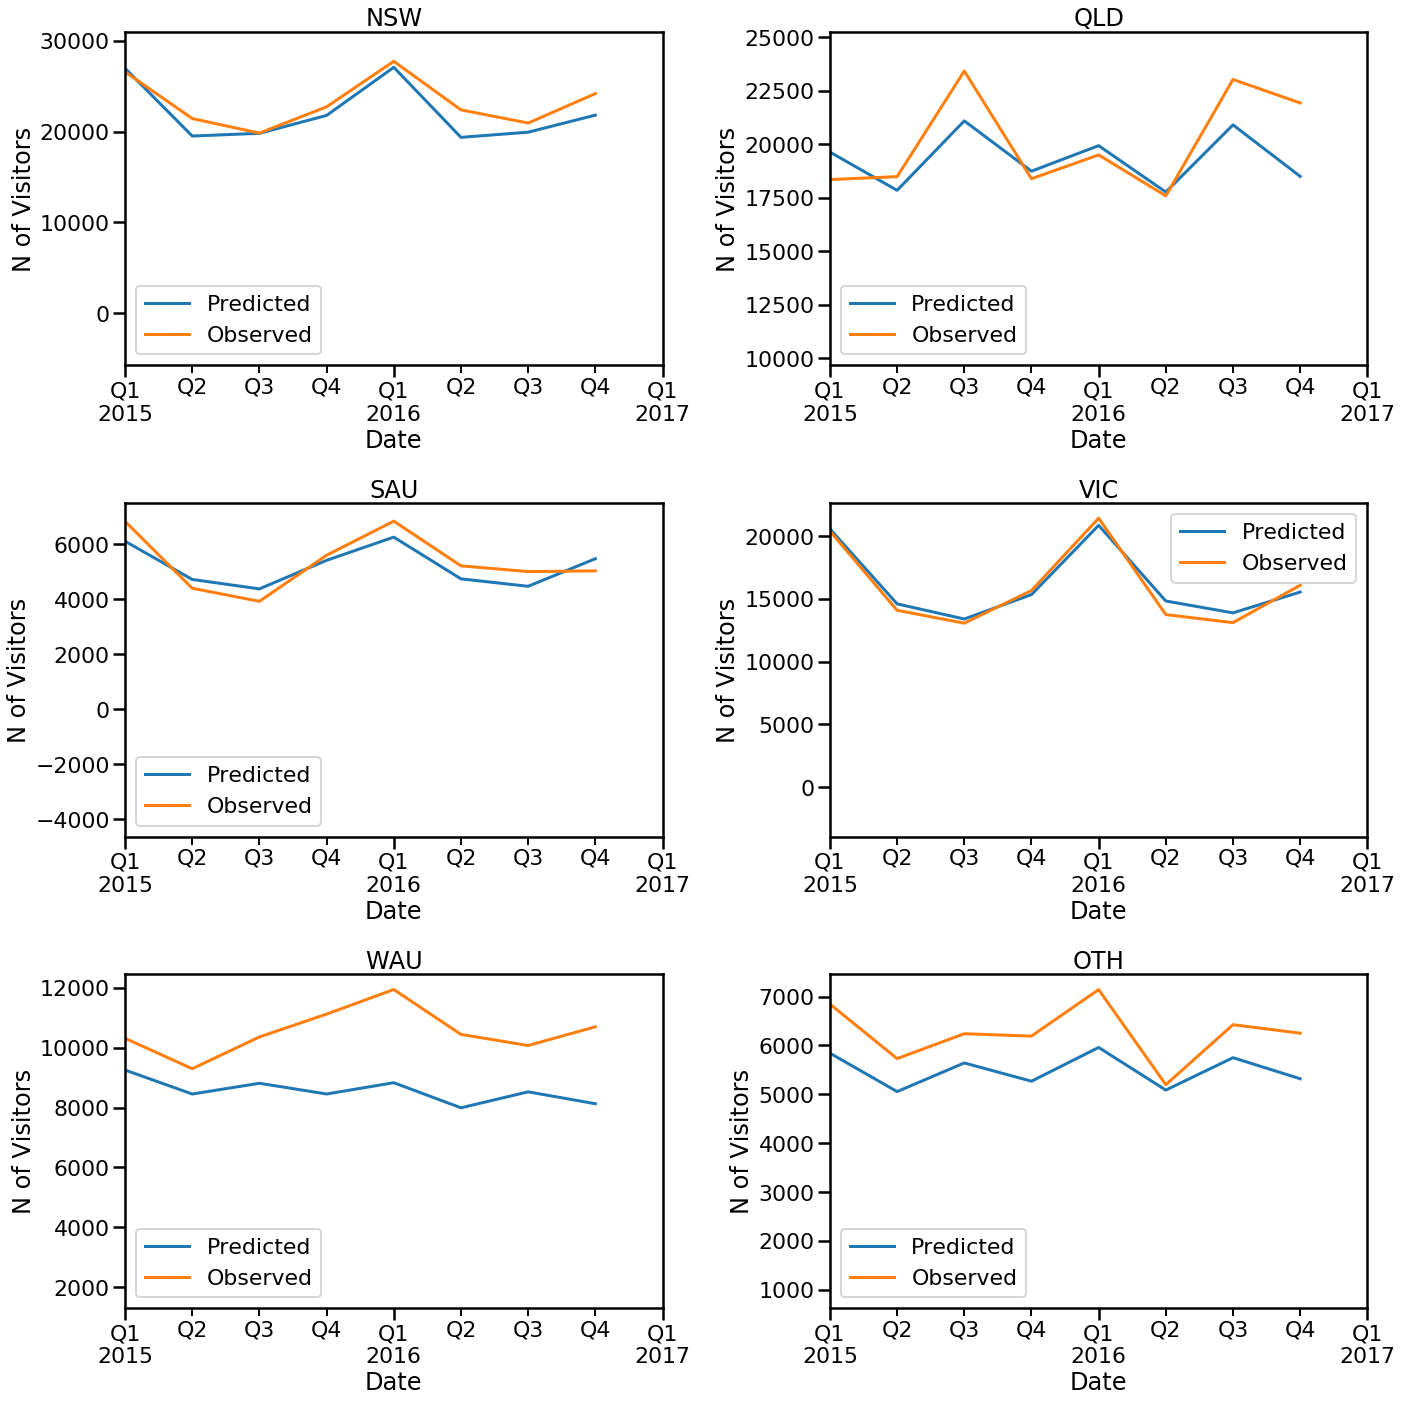

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=False)

def plot_results(cols, axes, preds):
    axes = np.hstack(axes)
    for ax, col in zip(axes, cols):
        preds[col].plot(ax=ax, label="Predicted")
        visnights_bottom_level[col].plot(ax=ax, label="Observed")

        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("N of Visitors")
        ax.set_xlim('2015', '2017')
    
plot_results(states, axes, predicted_autoarima)
plt.tight_layout()

In [89]:
import numpy
import pandas

__all__ = ['mean_absolute_scaled_error']

def mean_absolute_scaled_error(y_true, y_pred, y_train,
                              naive_period=1,
                              sample_weight=None,
                              multioutput='raw_values'):
    
    """Mean absolute scaled error


    Parameters
    ----------
    y_true : pandas.DataFrame of shape (n_samples,) or (n_samples, n_outputs)
        Observed test values of y.

    y_pred : pandas.DataFrame of shape (n_samples,) or (n_samples, n_outputs)
        Predicted / Forecasted values of y.
    
    y_train : pandas.DataFrame of shape (n_samples,) or (n_samples, n_outputs)
        Observed train values of y.

    multioutput : string in ['raw_values', 'uniform_average']
        raw_values: Returns metric for each node in dataset.
        unfirom_average: Returns average value for all nodes.

    Returns
    --------
    loss : 

    """
    
    in_sample_naive_forecast_errors = numpy.abs(
        y_train.diff(naive_period)[naive_period:]
        )
    
    in_sample_mae = in_sample_naive_forecast_errors.apply(numpy.average)

    e_t = numpy.abs(y_true - y_pred)
    q_t = (e_t / in_sample_mae)
    
    output_errors = q_t.apply(numpy.average, axis=0, weights=sample_weight)

    if isinstance(multioutput, str):
        if multioutput=='raw_values':
            return output_errors
        elif multioutput=='uniform_average':
            multioutput = None

    output_errors_avg = numpy.average(output_errors, weights=multioutput)

    return output_errors_avg

In [95]:
y_train = train
y_true = test
y_pred = predicted_autoarima[-y_true.shape[0]:]

In [96]:
train.shape, y_pred.shape, y_test.shape

((68, 27), (8, 27), (8, 27))

In [97]:
y_pred["SAU"]

2015-01-01    6117.032603
2015-04-01    4724.590723
2015-07-01    4382.015471
2015-10-01    5421.477510
2016-01-01    6265.618053
2016-04-01    4746.456618
2016-07-01    4475.859930
2016-10-01    5480.312461
Name: SAU, dtype: float64

In [99]:
mean_absolute_scaled_error(y_test, y_pred, y_train, naive_period=1, multioutput='uniform_average')

0.6915402831218967

In [33]:
y_pred = y_pred.rename(columns=lambda x: f"{x}_pred")
y_test = y_test.rename(columns=lambda x: f"{x}_test")

visnights_test = pd.concat([y_test, y_pred], axis=1)
visnights_test.to_csv("../data/preprocessed/visnights_test.csv")

In [48]:
visnights_test[[col for col in visnights_test.columns if "SAU" in col]]

SAU_Coast_test_test  SAU_Inner_test_test  SAU_Metro_test_test  \
2015-01-01          3037.088937          1164.554376          2639.272457   
2015-04-01          1490.527797          1164.906767          1748.306533   
2015-07-01           996.587955          1021.052059          1911.143762   
2015-10-01          1972.753277          1251.283598          2383.106677   
2016-01-01          2860.267133          1113.651544          2874.414086   
2016-04-01          1680.253613          1464.618322          2075.967278   
2016-07-01          1554.084728          1335.487584          2121.646116   
2016-10-01          1705.153209           925.070504          2407.232767   

            SAU_test_test  SAU_pred_pred  SAU_Coast_pred_pred  \
2015-01-01    6840.915770    6117.032603          2585.920757   
2015-04-01    4403.741097    4724.590723          1651.765025   
2015-07-01    3928.783776    4382.015471          1256.851165   
2015-10-01    5607.143552    5421.477510          1766.242974   
2016-01-01    6848.332763    6265.618053          2636.151249   
2016-04-01    5220.839212    4746.456618          1661.476225   
2016-07-01    5011.218428    4475.859930          1289.793718   
2016-10-01    5037.456480    5480.312461          1790.848355   

            SAU_Inner_pred_pred  SAU_Metro_pred_pred  
2015-01-01          1110.886285          2420.225561  
2015-04-01          1060.140859          2012.684839  
2015-07-01          1134.001013          1991.163293  
2015-10-01          1195.930822          2459.303715  
2016-01-01          1167.832271          2461.634533  
2016-04-01          1070.123483          2014.856910  
2016-07-01          1167.214992          2018.851220  
2016-10-01          1220.807629          2468.656477

In [47]:
naive_period = 1
in_sample_naive_forecast_errors = numpy.abs(
        y_train.diff(naive_period)[naive_period:]
        )

in_sample_mae = in_sample_naive_forecast_errors.apply(numpy.average)
in_sample_mae

state_zone
NSW_Metro    1007.792878
NSW_NthCo    1627.002304
NSW_NthIn     299.251558
NSW_SthCo    1515.581840
NSW_SthIn     430.694075
OTH_Metro     545.979065
OTH_NoMet     404.791053
QLD_Cntrl    1029.168288
QLD_Metro    1838.320085
QLD_NthCo    1352.625550
SAU_Coast     669.003523
SAU_Inner     175.379189
SAU_Metro     394.627905
VIC_EstCo     904.639506
VIC_Inner     569.723086
VIC_Metro    1445.283155
VIC_WstCo     776.667607
WAU_Coast     603.962861
WAU_Inner     202.184388
WAU_Metro     412.939247
NSW          3900.670132
QLD          3205.091664
SAU           874.612558
VIC          3529.177097
WAU           815.882935
OTH           861.311323
total        9904.649136
dtype: float64

In [51]:
e_t = numpy.abs(y_true - y_pred)
q_t = (e_t / in_sample_mae)
    
output_errors = numpy.average(q_t, axis=0, weights=None)

In [52]:
output_errors

array([0.33158752, 0.69103972, 0.28381174, 1.62641732, 0.11802138,
       0.32578991, 0.88557326, 0.89062295, 0.83277927, 0.42050717,
       0.61721818, 0.30652004, 0.30675203, 0.53151282, 0.31241583,
       0.88338661, 0.40473262, 0.15283841, 0.24247689, 0.43890816,
       0.10389305, 0.23921404, 2.42089504, 1.85975637, 1.62540539,
       1.34486822, 0.4746437 ])

In [167]:
clf.hts_result.models['SAU'].model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   68
Model:             SARIMAX(0, 0, 3)x(0, 1, 1, 4)   Log Likelihood                -478.096
Date:                           Sun, 10 May 2020   AIC                            968.191
Time:                                   22:32:44   BIC                            981.144
Sample:                                        0   HQIC                           973.294
                                            - 68                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.1917     22.150      0.144      0.885     -40.221      46.604
ma.L1         -0.0555      0.120     -0.461      0.645      -0.292       0.181
ma.L2          0.2113      0.159      1.328      0.184      -0.101       0.523
ma.L3          0.3210      0.149      2.158      0.031       0.029       0.613
ma.S.L4       -0.7545      0.157     -4.821      0.000      -1.061      -0.448
sigma2      1.537e+05    2.6e+04      5.919      0.000    1.03e+05    2.05e+05
===================================================================================
Ljung-Box (Q):                       43.68   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.32   Prob(JB):                         0.68
Heteroskedasticity (H):               0.96   Skew:                            -0.12
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

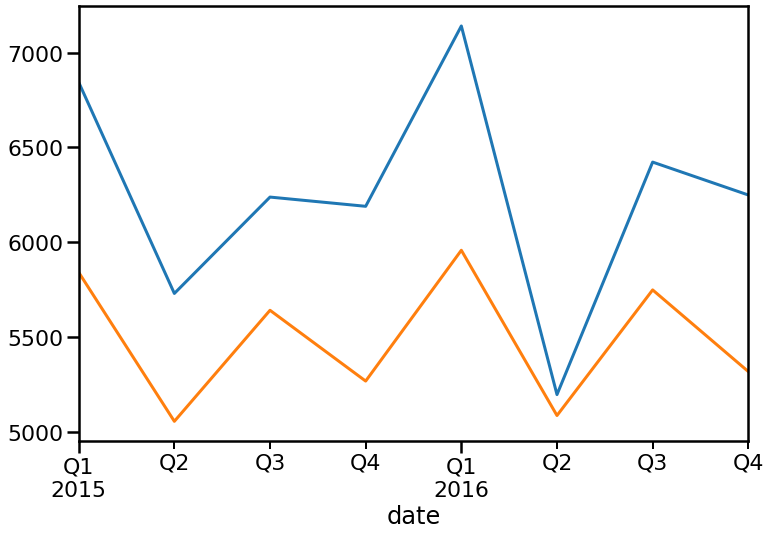

In [116]:
plt.subplots(figsize=(12, 8))

y_true["OTH"].plot()
y_pred["OTH"].plot()

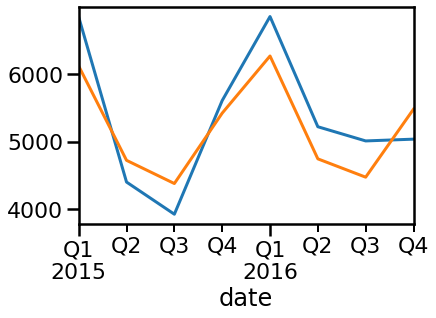

In [67]:
y_true["SAU"].plot()
y_pred["SAU"].plot()

In [120]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true['OTH'], y_pred['OTH'])

762.7542787523428

In [61]:
y_train['OTH'].diff(naive_period).apply(np.abs).mean()

463.75380955624985

In [119]:
mean_absolute_error(y_true['SAU'], y_pred['SAU'])

464.8677890882999

date
2015-01-01    5242.715403
2015-04-01    6840.915770
2015-07-01    4403.741097
2015-10-01    3928.783776
2016-01-01    5607.143552
2016-04-01    6848.332763
2016-07-01    5220.839212
2016-10-01    5011.218428
Freq: QS-JAN, Name: SAU, dtype: float64

In [125]:
y_true['SAU']

date
2015-01-01    6840.915770
2015-04-01    4403.741097
2015-07-01    3928.783776
2015-10-01    5607.143552
2016-01-01    6848.332763
2016-04-01    5220.839212
2016-07-01    5011.218428
2016-10-01    5037.456480
Freq: QS-JAN, Name: SAU, dtype: float64

In [128]:
mean_absolute_error(y_true['SAU'], visnights_bottom_level['SAU'].shift(4)[-y_true.shape[0]:])

555.6526920625001

In [129]:
mean_absolute_error(y_true['SAU'], y_pred['SAU'])

464.8677890882999

In [132]:
mean_absolute_error(y_true['NSW'], visnights_bottom_level['NSW'].shift(4)[-y_true.shape[0]:])

1007.8344071874994

In [133]:
mean_absolute_error(y_true['NSW'], y_pred['NSW'])

1293.4135500760767

In [ ]:
mean_absolute_scaled_error(y_true, y_pred, y_train, naive_period=4, multioutput='uniform_average')

In [62]:
y_train['SAU_Inner'].diff(naive_period).apply(np.abs).mean()

163.04046897656252

In [35]:
mean_absolute_scaled_error(y_true, y_pred, y_train, naive_period=4, multioutput='uniform_average')

array([2.07446256, 1.26937623, 1.24660544, 1.43732296, 0.57813661,
       0.30256524, 3.0833923 , 0.76881982, 0.38265984, 2.49034571,
       3.28403271, 3.4560864 , 1.33286633, 2.02148184, 0.54956419,
       0.29255913, 0.87740969, 0.93735822, 1.12160695, 0.74978737,
       0.1366432 , 0.1356808 , 4.40327024, 1.46724104, 0.39435256,
       0.88673542, 1.43873985])

In [44]:
pd.concat([y_true[get_state_columns(y_true, state='OTH')], y_pred[get_state_columns(y_pred, state='OTH')]], axis=1)

OTH_Metro    OTH_NoMet          OTH          OTH    OTH_Metro  \
2015-01-01  4269.451386  2574.935334  6844.386719  5840.603135  3546.124261   
2015-04-01  3718.575476  2010.583164  5729.158640  5053.849543  3403.277503   
2015-07-01  4419.010697  1819.065986  6238.076683  5640.265790  3725.121762   
2015-10-01  3809.972935  2379.367506  6189.340441  5266.394086  3573.830496   
2016-01-01  4288.449358  2853.100838  7141.550196  5957.242838  3654.153128   
2016-04-01  3278.023094  1917.089551  5195.112645  5084.556050  3424.380253   
2016-07-01  4290.924677  2131.902311  6422.826988  5747.841185  3782.070856   
2016-10-01  4233.837550  2015.249614  6249.087164  5316.752617  3601.909369   

              OTH_NoMet  
2015-01-01  2294.478874  
2015-04-01  1650.572040  
2015-07-01  1915.144029  
2015-10-01  1692.563589  
2016-01-01  2303.089710  
2016-04-01  1660.175797  
2016-07-01  1965.770329  
2016-10-01  1714.843248

In [30]:
df_mase = pd.DataFrame(zip(y_train.columns, mean_absolute_scaled_error(y_true, y_pred, y_train, naive_period=4)), 
                       columns=['level', 'mase'])
df_mase

level      mase
0   NSW_Metro  2.074463
1   NSW_NthCo  1.269376
2   NSW_NthIn  1.246605
3   NSW_SthCo  1.437323
4   NSW_SthIn  0.578137
5   OTH_Metro  0.302565
6   OTH_NoMet  3.083392
7   QLD_Cntrl  0.768820
8   QLD_Metro  0.382660
9   QLD_NthCo  2.490346
10  SAU_Coast  3.284033
11  SAU_Inner  3.456086
12  SAU_Metro  1.332866
13  VIC_EstCo  2.021482
14  VIC_Inner  0.549564
15  VIC_Metro  0.292559
16  VIC_WstCo  0.877410
17  WAU_Coast  0.937358
18  WAU_Inner  1.121607
19  WAU_Metro  0.749787
20        NSW  0.136643
21        QLD  0.135681
22        SAU  4.403270
23        VIC  1.467241
24        WAU  0.394353
25        OTH  0.886735
26      total  1.438740

In [20]:
clf.hts_result.models['total'].model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   68
Model:             SARIMAX(1, 0, 1)x(0, 1, 0, 4)   Log Likelihood                -620.481
Date:                           Sun, 10 May 2020   AIC                           1248.962
Time:                                   21:06:11   BIC                           1257.597
Sample:                                        0   HQIC                          1252.364
                                            - 68                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    244.1504    981.803      0.249      0.804   -1680.148    2168.449
ar.L1         -0.7662      0.083     -9.195      0.000      -0.930      -0.603
ma.L1          0.9986      0.182      5.485      0.000       0.642       1.355
sigma2      1.492e+07      0.008   1.95e+09      0.000    1.49e+07    1.49e+07
===================================================================================
Ljung-Box (Q):                       43.18   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.34   Prob(JB):                         0.61
Heteroskedasticity (H):               1.48   Skew:                            -0.29
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.92e+26. Standard errors may be unstable.
"""

Of course, you can also check results for specific, nodes, let's get for OTH:

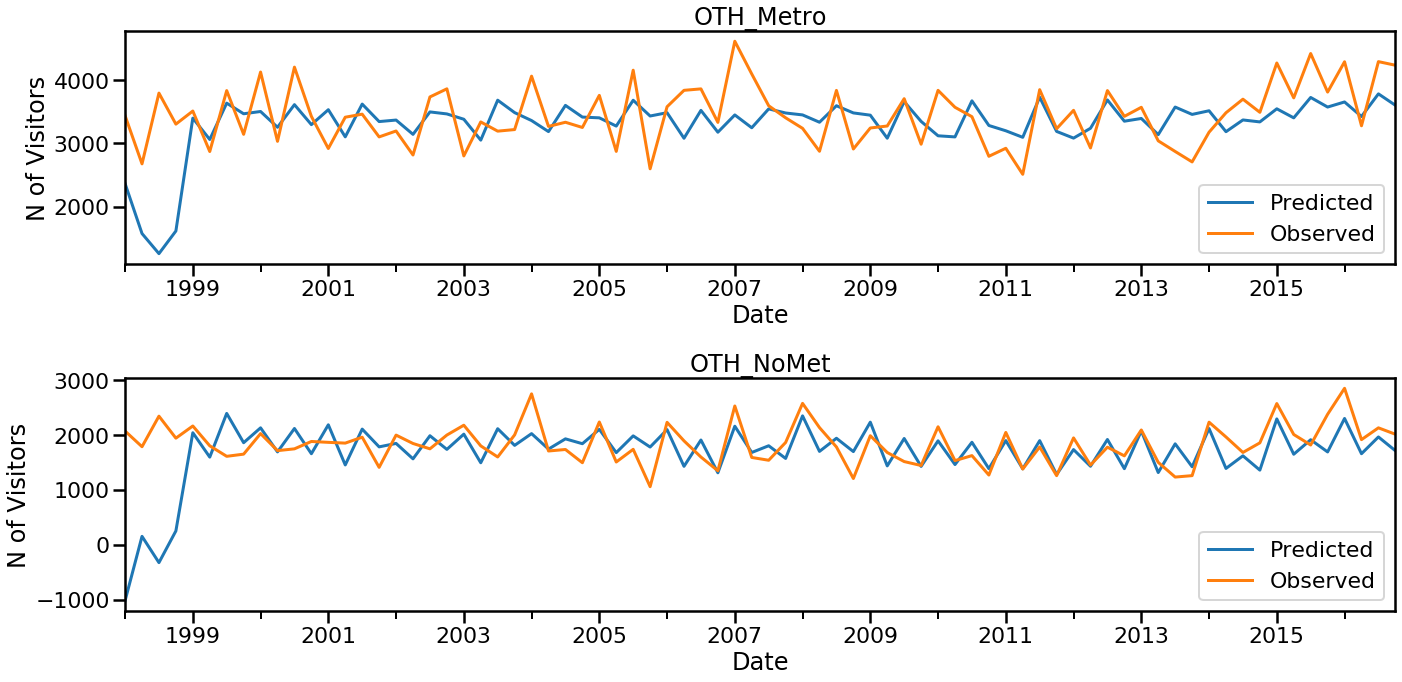

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
plot_results(state_cols, axes, predicted_autoarima)
plt.tight_layout()

#### Prophet

We can do the same fit as above, but now for prophet model.

In [27]:
clf = HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
model = clf.fit(visnights_bottom_level, hierarchy)

Fitting models: 100%|██████████| 27/27 [00:17<00:00,  1.51it/s]


In [28]:
predicted_prophet = model.predict(steps_ahead=8)

Fitting models: 100%|██████████| 27/27 [00:34<00:00,  1.27s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fde09e1f290>


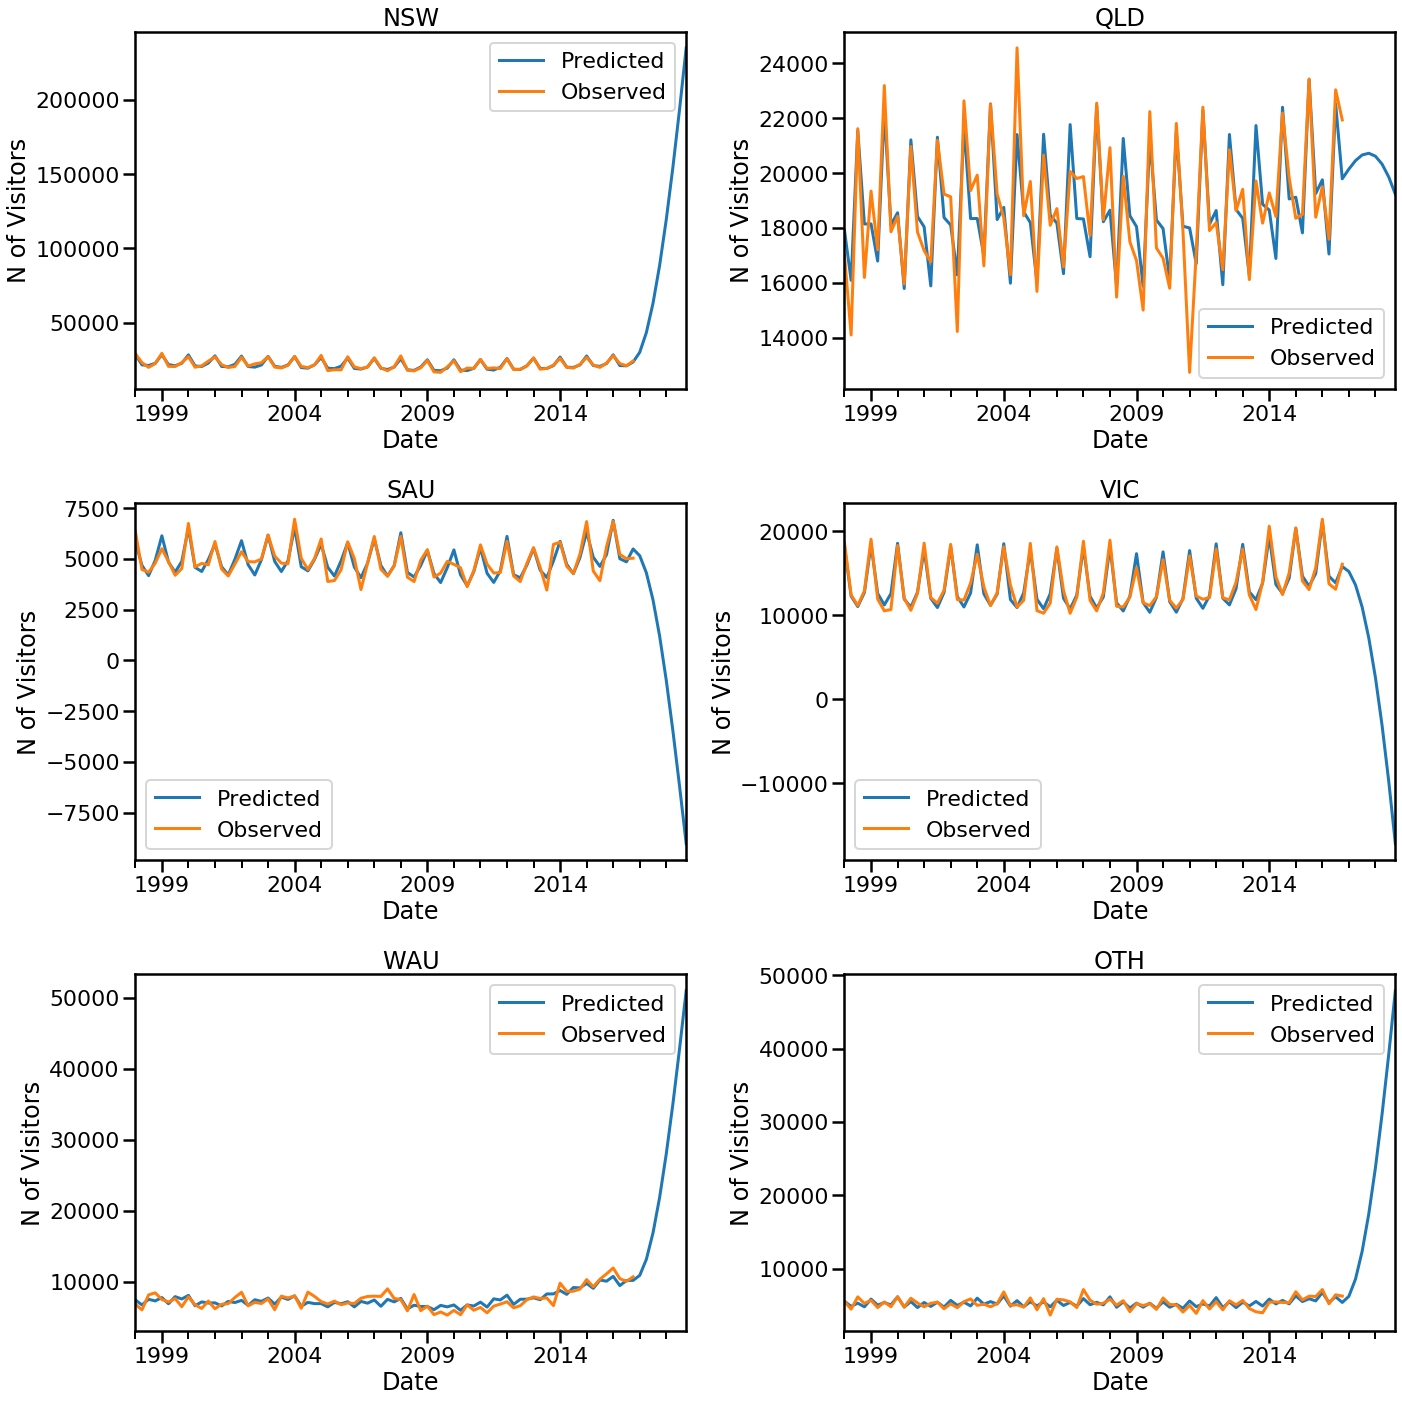

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
plot_results(states, axes, predicted_prophet)
plt.tight_layout()

In [58]:
def hierarchical_visnights_data():
    vis_idx = pandas.date_range(start="1998-01-01", periods=8, freq="QS")
    vis_values = {
        'NSW_Metro': [9047, 6962, 6872, 7147, 7957, 6542, 6330, 7509],
        'NSW_NthCo': [8566, 7124, 4717, 6269, 9494, 5401, 5543, 6383],
        'NSW_NthIn': [2978, 3478, 3015, 3758, 3791, 3395, 3626, 3691],
        'NSW_SthCo': [5818, 2466, 1928, 2798, 4854, 2760, 2042, 2651],
        'NSW_SthIn': [2680, 3011, 3329, 2418, 3224, 2428, 2893, 2815],
        'OTH_Metro': [3438, 2677, 3794, 3304, 3511, 2872, 3833, 3143],
        'OTH_NoMet': [2073, 1788, 2345, 1944, 2166, 1804, 1613, 1652],
        'QLD_Cntrl': [2748, 4041, 5344, 4260, 4186, 4238, 6415, 3710],
        'QLD_Metro': [12106, 7787, 11380, 9311, 12672, 9583, 11193, 9871],
        'QLD_NthCo': [2137, 2270, 4890, 2622, 2483, 3378, 5578, 4279],
        'SAU_Coast': [2592, 1376, 1080, 1498, 2248, 1673, 1105, 1503],
        'SAU_Inner': [895, 979, 980, 1509, 964, 997, 1058, 771],
        'SAU_Metro': [2881, 2125, 2285, 1786, 2294, 2197, 2034, 2253],
        'VIC_EstCo': [3382, 1828, 1352, 1493, 2897, 1548, 914, 1342],
        'VIC_Inner': [5327, 4441, 3816, 3860, 4589, 4070, 4114, 3723],
        'VIC_Metro': [7490, 5198, 5244, 6274, 9187, 4992, 4746, 4685],
        'VIC_WstCo': [2442, 961, 756, 1272, 2385, 1329, 759, 942],
        'WAU_Coast': [3067, 3334, 4366, 4522, 3579, 3409, 3979, 3365],
        'WAU_Inner': [695, 558, 1006, 1173, 398, 596, 951, 832],
        'WAU_Metro': [3076, 2155, 2787, 2753, 3520, 3160, 2708, 2294],
        'NSW': [29088, 23041, 19861, 22390, 29320, 20527, 20434, 23049],
        'QLD': [16992, 14097, 21614, 16193, 19341, 17199, 23186, 17861],
        'SAU': [6368, 4480, 4345, 4793, 5505, 4867, 4196, 4526],
        'VIC': [18641, 12428, 11168, 12899, 19058, 11939, 10534, 10692],
        'WAU': [6837, 6047, 8159, 8447, 7497, 7165, 7638, 6491],
        'OTH': [5511, 4465, 6139, 5248, 5677, 4676, 5446, 4796],
        'total': [83437, 64558, 71285, 69971, 86398, 66373, 71434, 67415]
    }

    return pandas.DataFrame(vis_values, index=vis_idx)

In [59]:
data = hierarchical_visnights_data()

data.head(5)

NSW_Metro  NSW_NthCo  NSW_NthIn  NSW_SthCo  NSW_SthIn  OTH_Metro  \
1998-01-01       9047       8566       2978       5818       2680       3438   
1998-04-01       6962       7124       3478       2466       3011       2677   
1998-07-01       6872       4717       3015       1928       3329       3794   
1998-10-01       7147       6269       3758       2798       2418       3304   
1999-01-01       7957       9494       3791       4854       3224       3511   

            OTH_NoMet  QLD_Cntrl  QLD_Metro  QLD_NthCo  ...  WAU_Coast  \
1998-01-01       2073       2748      12106       2137  ...       3067   
1998-04-01       1788       4041       7787       2270  ...       3334   
1998-07-01       2345       5344      11380       4890  ...       4366   
1998-10-01       1944       4260       9311       2622  ...       4522   
1999-01-01       2166       4186      12672       2483  ...       3579   

            WAU_Inner  WAU_Metro    NSW    QLD   SAU    VIC   WAU   OTH  total  
1998-01-01        695       3076  29088  16992  6368  18641  6837  5511  83437  
1998-04-01        558       2155  23041  14097  4480  12428  6047  4465  64558  
1998-07-01       1006       2787  19861  21614  4345  11168  8159  6139  71285  
1998-10-01       1173       2753  22390  16193  4793  12899  8447  5248  69971  
1999-01-01        398       3520  29320  19341  5505  19058  7497  5677  86398  

[5 rows x 27 columns]

In [101]:
y_train = data.iloc[:6, :]
y_true = data.iloc[6:, :]
y_pred = data.iloc[6:, :]

In [102]:
naive_period = 1
in_sample_naive_forecast_errors = numpy.abs(
        y_train.diff(naive_period)[naive_period:]
        )

in_sample_mae = in_sample_naive_forecast_errors.apply(numpy.average)
in_sample_mae

NSW_Metro      935.0
NSW_NthCo     2543.8
NSW_NthIn      427.0
NSW_SthCo     1782.0
NSW_SthIn      632.4
OTH_Metro      642.8
OTH_NoMet      365.4
QLD_Cntrl      761.2
QLD_Metro     3286.2
QLD_NthCo     1211.0
SAU_Coast      651.0
SAU_Inner      238.4
SAU_Metro      404.0
VIC_EstCo      984.8
VIC_Inner      560.6
VIC_Metro     2095.2
VIC_WstCo      874.2
WAU_Coast      513.6
WAU_Inner      345.0
WAU_Metro      542.8
NSW           5495.8
QLD           4224.6
SAU            764.2
VIC           4496.4
WAU            894.4
OTH           1008.2
total        12674.4
dtype: float64

In [105]:
y_pred *= 1/5
mean_absolute_scaled_error(y_true, y_pred, y_train, naive_period=1)

NSW_Metro    5.920428
NSW_NthCo    1.875305
NSW_NthIn    6.854333
NSW_SthCo    1.053423
NSW_SthIn    3.610373
OTH_Metro    4.341008
OTH_NoMet    3.574165
QLD_Cntrl    5.320547
QLD_Metro    2.563934
QLD_NthCo    3.255822
SAU_Coast    1.602458
SAU_Inner    3.068792
SAU_Metro    4.244554
VIC_EstCo    0.916328
VIC_Inner    5.591866
VIC_Metro    1.800496
VIC_WstCo    0.778312
WAU_Coast    5.719626
WAU_Inner    2.067246
WAU_Metro    3.686072
NSW          3.164817
QLD          3.886474
SAU          4.565297
VIC          1.888266
WAU          6.318873
OTH          4.063479
total        4.382030
dtype: float64

In [85]:
np.random.seed = 1
y_pre

NSW_Metro     NSW_NthCo    NSW_NthIn    NSW_SthCo    NSW_SthIn  \
1999-07-01  13249.096523  11505.671174  7285.733858  4388.802378  5746.521269   
1999-10-01  14426.929016  12347.925661  7350.631013  4997.385125  5669.954383   

              OTH_Metro    OTH_NoMet     QLD_Cntrl     QLD_Metro  \
1999-07-01  7321.066710  3246.291280  11476.874588  21724.615012   
1999-10-01  6630.976009  3284.156433   8771.093486  20401.547173   

               QLD_NthCo  ...    WAU_Coast    WAU_Inner    WAU_Metro  \
1999-07-01  10507.062067  ...  7649.517040  1842.170836  5209.387815   
1999-10-01   9207.305018  ...  7036.748113  1723.111520  4793.602317   

                     NSW           QLD          SAU           VIC  \
1999-07-01  42174.712491  43708.159162  8558.479499  21145.748344   
1999-10-01  44789.841604  38382.611456  8887.895883  21305.484923   

                     WAU           OTH          total  
1999-07-01  14703.651256  10564.779443  140857.399215  
1999-10-01  13554.412795   9916.444072  136840.710350  

[2 rows x 27 columns]

In [84]:
y_true

NSW_Metro  NSW_NthCo  NSW_NthIn  NSW_SthCo  NSW_SthIn  OTH_Metro  \
1999-07-01       6330       5543       3626       2042       2893       3833   
1999-10-01       7509       6383       3691       2651       2815       3143   

            OTH_NoMet  QLD_Cntrl  QLD_Metro  QLD_NthCo  ...  WAU_Coast  \
1999-07-01       1613       6415      11193       5578  ...       3979   
1999-10-01       1652       3710       9871       4279  ...       3365   

            WAU_Inner  WAU_Metro    NSW    QLD   SAU    VIC   WAU   OTH  total  
1999-07-01        951       2708  20434  23186  4196  10534  7638  5446  71434  
1999-10-01        832       2294  23049  17861  4526  10692  6491  4796  67415  

[2 rows x 27 columns]

In [77]:

np.random.seed = 1
np.random.normal

<function RandomState.normal>

In [66]:
np.all(mean_absolute_scaled_error(y_true, y_pred, y_train, naive_period=1) == 0)

True

In [114]:
np.sqrt(model.hts_result.errors['total'])

17028.96382976143